In [1]:
from plotly import __version__
from plotly.offline import init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter

init_notebook_mode() #cach dong

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import pycountry
import plotly.express as px
from collections import namedtuple

In [3]:
import plotly.io as pio
pio.templates.default = "plotly_dark"
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm as tqdm

In [4]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import itertools
import statsmodels.api as sm
#Import the required modules for test statistic calculation:
import statsmodels.stats as sm_stat
#Import the required modules for model estimation:
import statsmodels.tsa as smt

In [5]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [6]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    
    
    return({'MAPE': mape, 'ME':me, 'MAE': mae, 
            'MPE': mpe, 'RMSE':rmse})

In [7]:
data = pd.read_csv('covid_19_data.csv', parse_dates=['ObservationDate'])
data.rename(columns={'ObservationDate':'Date'}, inplace=True)
data.tail()

,SNo,Date,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
14806,14807,2020-04-13,Wyoming,US,2020-04-13 23:15:42,275.0,1.0,0.0
14807,14808,2020-04-13,Xinjiang,Mainland China,2020-04-13 23:15:42,76.0,3.0,73.0
14808,14809,2020-04-13,Yukon,Canada,2020-04-13 23:15:42,8.0,0.0,0.0
14809,14810,2020-04-13,Yunnan,Mainland China,2020-04-13 23:15:42,184.0,2.0,174.0
14810,14811,2020-04-13,Zhejiang,Mainland China,2020-04-13 23:15:42,1267.0,1.0,1239.0


In [8]:
# cases 
cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
data['Active'] = data['Confirmed'] - data['Deaths'] - data['Recovered']

# filling missing values 
data[cases] = data[cases].fillna(0)

data.head()

,SNo,Date,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Active
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,1.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0,14.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0,6.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0,1.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0,0.0


In [9]:
grouped_uk = data[data['Country/Region'] == "UK"].reset_index()
grouped_uk_date = grouped_uk.groupby('Date')['Date', 'Confirmed', 'Deaths','Recovered','Active'].sum().reset_index()
grouped_uk_date

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,Date,Confirmed,Deaths,Recovered,Active
0,2020-01-31,2.0,0.0,0.0,2.0
1,2020-02-01,2.0,0.0,0.0,2.0
2,2020-02-02,2.0,0.0,0.0,2.0
3,2020-02-03,2.0,0.0,0.0,2.0
4,2020-02-04,2.0,0.0,0.0,2.0
...,...,...,...,...,...
69,2020-04-09,65872.0,7993.0,359.0,57520.0
70,2020-04-10,74605.0,8974.0,588.0,65043.0
71,2020-04-11,79874.0,9892.0,622.0,69360.0
72,2020-04-12,85206.0,10629.0,626.0,73951.0


In [10]:
#PLOT UK CASES
fig = make_subplots(rows=1, cols=4, subplot_titles=("Comfirmed", "Deaths", "Recovered",'Active'))

trace1 = go.Scatter(x=grouped_uk_date['Date'],y=grouped_uk_date['Confirmed'],name="Confirmed",line_color='orange',mode='lines+markers',opacity=0.8)
trace2 = go.Scatter(x=grouped_uk_date['Date'],y=grouped_uk_date['Deaths'],name="Deaths",line_color='red',mode='lines+markers',opacity=0.8)
trace3 = go.Scatter(x=grouped_uk_date['Date'],y=grouped_uk_date['Recovered'],name="Recovered",mode='lines+markers',line_color='green',opacity=0.8)
trace4 = go.Scatter(x=grouped_uk_date['Date'],y=grouped_uk_date['Active'],name="Active",line_color='blue',mode='lines+markers',opacity=0.8)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 1, 4)
fig.update_layout(template="plotly_dark",title_text = '<b>Spread of the Coronavirus Over Time in the UK </b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='white'))
#fig.update_yaxes(type="log")
plot(fig)

'temp-plot.html'

In [11]:
grouped_uk_date['Date'] = pd.to_datetime(grouped_uk_date['Date'])
grouped_uk_date.set_index('Date', inplace=True)

In [12]:
#PLOT US CONFIRMED CASES
fig = go.Figure()

fig.add_trace(go.Scatter(x=grouped_uk_date.index,y=grouped_uk_date['Confirmed'],
                         name="Confirmed",line_color='orange',mode='lines+markers',opacity=0.8))

fig.update_layout(template="plotly_dark",title_text = '<b>Spread of the Confirmed cases Over Time in the UK (Log Scale) </b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='white'))
fig.update_yaxes(type="log")
plot(fig)

'temp-plot.html'

In [13]:
#LOG PLOT
fig = go.Figure()

fig.add_trace(go.Scatter(x=train_uk_log.index,y=train_uk_log['Confirmed'],
                         name="Confirmed",line_color='orange',mode='lines+markers',opacity=0.8))

fig.update_layout(template="plotly_dark",title_text = '<b>Log of the Confirmed cases Over Time in the UK </b>',
                  font=dict(family="Arial, Balto, Courier New, Droid Sans",color='white'))
plot(fig)

NameError: name 'train_uk_log' is not defined

In [15]:
uk_confirm = grouped_uk_date.drop(['Deaths', 'Recovered', 'Active'], axis=1)
uk_confirm

,Confirmed
Date,
2020-01-31,2.0
2020-02-01,2.0
2020-02-02,2.0
2020-02-03,2.0
2020-02-04,2.0
...,...
2020-04-09,65872.0
2020-04-10,74605.0
2020-04-11,79874.0


In [16]:
#uk_new =  uk_confirm - uk_confirm.shift().fillna(0)
uk_new = uk_confirm[10:]
len(uk_new)

64

In [17]:
uk_new

,Confirmed
Date,
2020-02-10,8.0
2020-02-11,8.0
2020-02-12,9.0
2020-02-13,9.0
2020-02-14,9.0
...,...
2020-04-09,65872.0
2020-04-10,74605.0
2020-04-11,79874.0


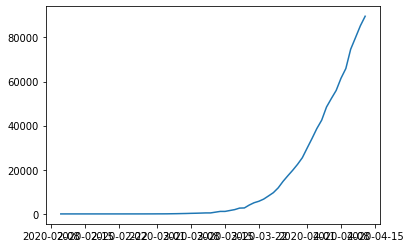

In [18]:
plt.plot(uk_new)

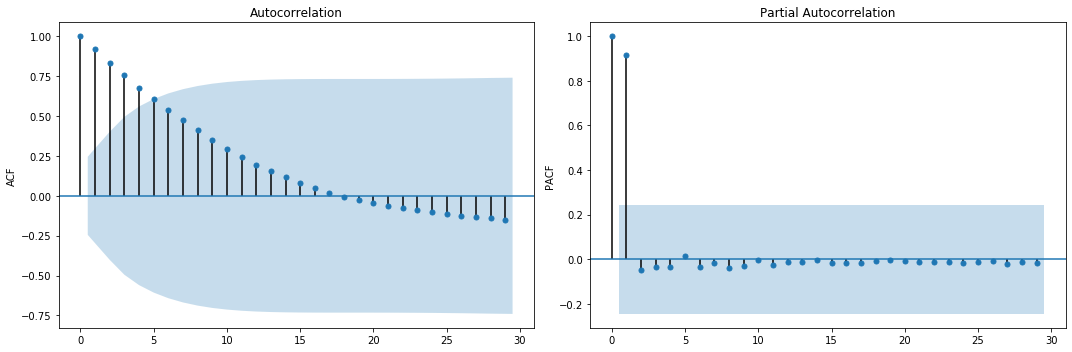

In [19]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(uk_new, lags = 29, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(uk_new, lags = 29, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

In [20]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(train_uk, lags = 29, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(train_uk, lags = 29, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

NameError: name 'train_uk' is not defined

<Figure size 1080x360 with 0 Axes>

In [22]:
train_uk = uk_new[:44]
test_uk = uk_new[44:]
uk_new_log = np.log(uk_new)
test_uk_log = np.log(test_uk)
train_uk_log = np.log(train_uk)
#train_uk_log_diff = train_uk_log - train_uk_log.shift()
#train_uk_log_diff.dropna(inplace=True)

In [23]:
train_uk_diff = train_uk - train_uk.shift()
train_uk_diff.dropna(inplace=True)

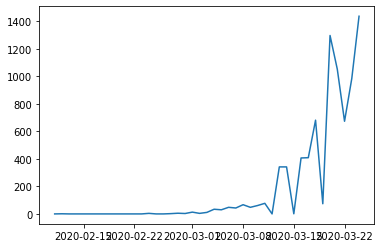

In [24]:
plt.plot(train_uk_diff)

In [25]:
train_uk_diff

,Confirmed
Date,
2020-02-11,0.0
2020-02-12,1.0
2020-02-13,0.0
2020-02-14,0.0
2020-02-15,0.0
2020-02-16,0.0
2020-02-17,0.0
2020-02-18,0.0
2020-02-19,0.0


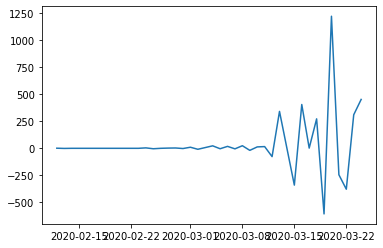

In [26]:
train_uk_diff2 = train_uk_diff - train_uk_diff.shift()
train_uk_diff2.dropna(inplace=True)
plt.plot(train_uk_diff2)

NameError: name 'train_uk_diff22' is not defined

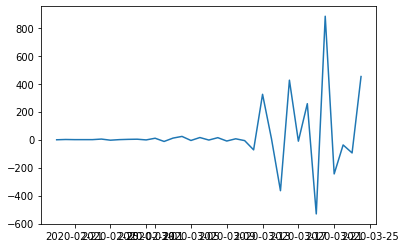

In [27]:
train_uk_diff2_seasonal = train_uk_diff2.diff(7)
train_uk_diff2_seasonal.dropna(inplace=True)
plt.plot(train_uk_diff2_seasonal)
plt.plot(train_uk_diff22)

In [28]:
adf_test(train_uk_diff2_seasonal)

Results of Dickey-Fuller Test:
Test Statistic                 -2.488739
p-value                         0.118238
#Lags Used                     10.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


In [ ]:
# Create figure
fig, (ax1, ax2) = plt.subplots(2,1)
# Plot seasonal ACF
plot_acf(train_uk_diff2_seasonal, ax=ax1)
# Plot seasonal PACF
plot_pacf(train_uk_diff2_seasonal, ax=ax2)
plt.show()

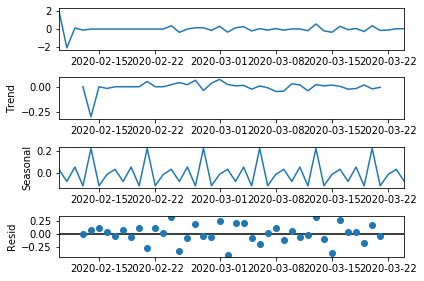

In [157]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose data
decomp_results = seasonal_decompose(train_uk_log_diff2)
decomp_results.plot()
plt.savefig('decompose.pdf')
plt.show()

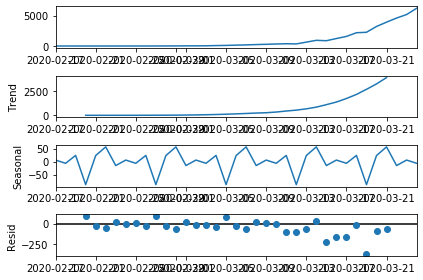

In [138]:
train_uk_season7 = train_uk.diff(7)
train_uk_season7.dropna(inplace=True)
decomp_results = seasonal_decompose(train_uk_season7)
decomp_results.plot()
plt.show()

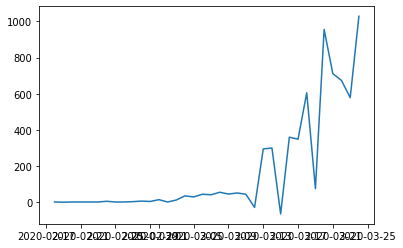

In [139]:
train_uk_diff = train_uk_season7 - train_uk_season7.shift()
train_uk_diff.dropna(inplace=True)
plt.plot(train_uk_diff)

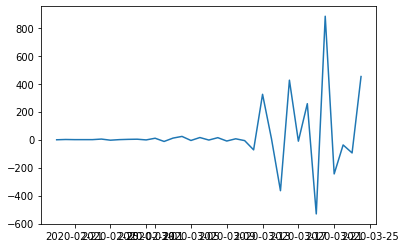

In [140]:
train_uk_diff22 = train_uk_diff - train_uk_diff.shift()
train_uk_diff22.dropna(inplace=True)
plt.plot(train_uk_diff22)

In [150]:
import pmdarima as pm
results = pm.auto_arima(train_uk_log, seasonal = True, m=7, trace = True, error_action ='ignore', # ignore orders that don't work
                        stepwise=True, information_criterion= 'aic')

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(2, 2, 2) seasonal_order=(1, 0, 1, 7); AIC=-31.631, BIC=-17.730, Fit time=0.496 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 7); AIC=-14.191, BIC=-10.715, Fit time=0.020 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 0, 0, 7); AIC=-23.558, BIC=-16.607, Fit time=0.050 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 1, 7); AIC=-36.354, BIC=-29.403, Fit time=0.216 seconds


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 1, 7); AIC=-35.419, BIC=-26.731, Fit time=0.301 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 7); AIC=-37.930, BIC=-32.717, Fit time=0.072 seconds
Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 7); AIC=-36.910, BIC=-29.960, Fit time=0.128 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 7); AIC=-37.830, BIC=-30.879, Fit time=0.162 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 7); AIC=-36.296, BIC=-27.607, Fit time=0.205 seconds


/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Fit ARIMA: order=(0, 2, 1) seasonal_order=(1, 0, 0, 7); AIC=-36.275, BIC=-29.324, Fit time=0.242 seconds
Total fit time: 1.918 seconds


In [152]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:               SARIMAX(0, 2, 1)   Log Likelihood                  21.965
Date:                Mon, 20 Apr 2020   AIC                            -37.930
Time:                        10:00:58   BIC                            -32.717
Sample:                             0   HQIC                           -36.019
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0052      0.005      1.161      0.246      -0.004       0.014
ma.L1         -0.8188      0.101     -8.130      0.000      -1.016      -0.621
sigma2         0.0200      0.004      4.941      0.0

In [29]:
mod = sm.tsa.SARIMAX(train_uk_log, order=(3, 1, 1))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                   44
Model:               SARIMAX(3, 1, 1)   Log Likelihood                  24.116
Date:                Fri, 01 May 2020   AIC                            -38.232
Time:                        01:49:00   BIC                            -29.426
Sample:                    02-10-2020   HQIC                           -34.985
                         - 03-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5337      0.288      1.854      0.064      -0.030       1.098
ar.L2          0.1051      0.192      0.548      0.584      -0.271       0.481
ar.L3          0.3131      0.211      1.481      0.1

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [30]:
mod2 = sm.tsa.SARIMAX(uk_new, order=(3, 1, 1))
res2 = mod2.smooth(res.params)
print(res2.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                   64
Model:               SARIMAX(3, 1, 1)   Log Likelihood         -1501909145.507
Date:                Fri, 01 May 2020   AIC                     3003818301.014
Time:                        01:49:34   BIC                     3003818311.730
Sample:                    02-10-2020   HQIC                    3003818305.228
                         - 04-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5337   8.17e-09   6.53e+07      0.000       0.534       0.534
ar.L2          0.1051   5.92e-09   1.78e+07      0.000       0.105       0.105
ar.L3          0.3131   5.73e-09   5.46e+07      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [31]:
fc=res2.predict(start=44, end=len(uk_new_log)-1)
y_pred=fc
y_pred = np.array(y_pred, dtype='int')
y_test = test_uk['Confirmed'].values
df = {'Prediction values':  y_pred,
        'Actual values': y_test
        }
df = pd.DataFrame (df, columns = ['Prediction values','Actual values' ])
df.set_index(test_uk.index, inplace=True)
df

,Prediction values,Actual values
Date,,
2020-03-25,8941,9640.0
2020-03-26,10545,11812.0
2020-03-27,12957,14745.0
2020-03-28,16127,17312.0
2020-03-29,19091,19780.0
2020-03-30,21948,22453.0
2020-03-31,24696,25481.0
2020-04-01,27767,29865.0
2020-04-02,32334,34173.0


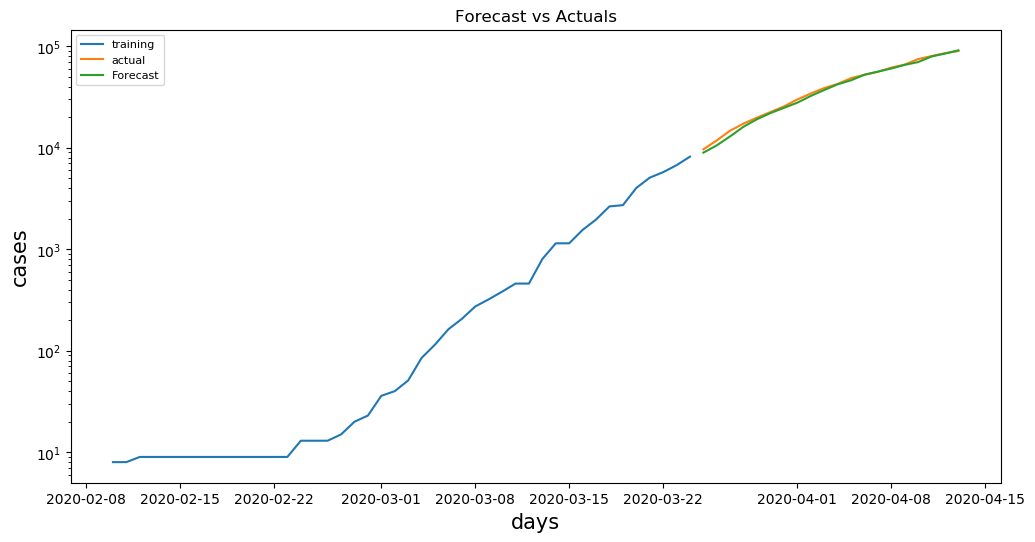

In [33]:
# Plot real one -step forecasr
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_uk['Confirmed'], label='training')
plt.plot(test_uk['Confirmed'], label='actual')
plt.plot(res2.predict(start=44, end=len(uk_new_log)-1), label = 'Forecast')
#plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('days', fontsize=15)
plt.ylabel('cases', fontsize=15)
plt.yscale('log')
plt.savefig('logfig1.png')
plt.show()

In [ ]:
# Plot real
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_uk['Confirmed'], label='training')
plt.plot(test_uk['Confirmed'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('days', fontsize=15)
plt.ylabel('cases', fontsize=15)
#plt.yscale('log')
plt.show()

In [160]:
forecast_accuracy(y_pred, y_test)

{'MAPE': 3.662701788054664,
 'ME': -929.1,
 'MAE': 1090.8,
 'MPE': -0.0343780185183461,
 'RMSE': 1484.066339487558}

In [18]:
uk_new_log

,Confirmed
Date,
2020-02-10,2.079442
2020-02-11,2.079442
2020-02-12,2.197225
2020-02-13,2.197225
2020-02-14,2.197225
...,...
2020-04-09,11.095469
2020-04-10,11.219963
2020-04-11,11.288206


In [19]:
uk_new_log['Confirmed'][np.isneginf(uk_new_log['Confirmed'])] = 0

In [92]:
train_uk_log['Confirmed'][np.isneginf(train_uk_log['Confirmed'])] = 0

In [93]:
adf_test(train_uk_log)

Results of Dickey-Fuller Test:
Test Statistic                  2.705925
p-value                         0.999087
#Lags Used                      0.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


In [94]:
train_uk_log_diff =  train_uk_log - train_uk_log.shift().fillna(0)
train_uk_log_diff

,Confirmed
Date,
2020-02-10,2.079442
2020-02-11,0.000000
2020-02-12,0.117783
2020-02-13,0.000000
2020-02-14,0.000000
2020-02-15,0.000000
2020-02-16,0.000000
2020-02-17,0.000000
2020-02-18,0.000000


In [156]:
train_uk_log_diff2= train_uk_log_diff - train_uk_log_diff.shift().fillna(0)
train_uk_log_diff2

,Confirmed
Date,
2020-02-10,2.079442
2020-02-11,-2.079442
2020-02-12,0.117783
2020-02-13,-0.117783
2020-02-14,0.000000
2020-02-15,0.000000
2020-02-16,0.000000
2020-02-17,0.000000
2020-02-18,0.000000


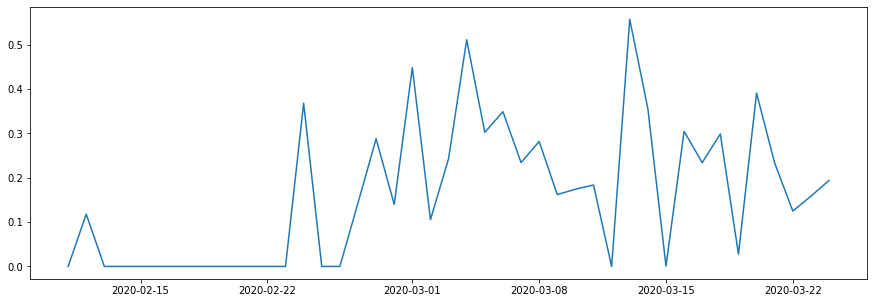

In [95]:
fig = plt.figure(figsize=(15, 5))
plt.plot(train_uk_log_diff[1:])

In [497]:
adf_test(train_uk_log_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.341252e+01
p-value                        4.345625e-25
#Lags Used                     0.000000e+00
Number of Observations Used    4.300000e+01
Critical Value (1%)           -3.592504e+00
Critical Value (5%)           -2.931550e+00
Critical Value (10%)          -2.604066e+00
dtype: float64


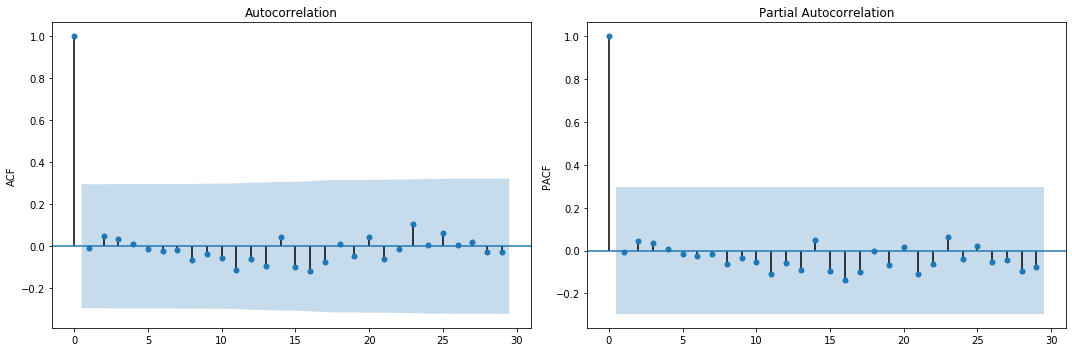

In [498]:
fig = plt.figure(figsize=(15, 5))
sm.tsa.graphics.plot_acf(train_uk_log_diff, lags = 29, ax = fig.add_subplot(121))
plt.ylabel('ACF')
sm.tsa.graphics.plot_pacf(train_uk_log_diff, lags = 29, ax = fig.add_subplot(122), method = "ywm")
plt.ylabel('PACF')
plt.tight_layout()

In [499]:
model_auto = sm.tsa.stattools.arma_order_select_ic(train_uk_log_diff[1:], ic='aic', trend='c')

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:716: RuntimeWarning:

divide by zero encountered in true_divide

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning:

invalid value encountered in true_divide

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning:

invalid value encountered in true_divide



In [500]:
model_auto

{'aic':            0          1          2
 0 -32.247459 -32.251814 -31.115681
 1 -33.061590 -28.304984 -38.998374
 2 -33.583311 -37.331756 -25.139442
 3 -37.930273 -38.110458 -36.879340
 4 -38.302562 -36.498417        NaN,
 'aic_min_order': (1, 2)}

In [501]:
print("(A) process order: ", model_auto.aic_min_order)

(A) process order:  (1, 2)


In [606]:

model = ARIMA(train_uk_log, order=(1,1, 2))
model_fit = model.fit(disp= -1)
model_fit.summary()

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.Confirmed   No. Observations:                   43
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  24.499
Method:                       css-mle   S.D. of innovations              0.136
Date:                Tue, 14 Apr 2020   AIC                            -38.998
Time:                        17:37:05   BIC                            -30.192
Sample:                    02-11-2020   HQIC                           -35.751
                         - 03-24-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1461      0.064      2.284      0.022       0.021       0.271
ar.L1.D.Confirmed     0.9038      0.082     11.068      0.000       0.744       1.064
ma.L1.D.Confirmed    -0.9956      0.177     -5.635      0.000      -1.342      -0.649
ma.L2.D.Confirmed     0.3424      0.173      1.975      0.048       0.003       0.682
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1065           +0.0000j            1.1065            0.0000
MA.1            1.4538           -0.8983j            1.7089           -0.0881
MA.2            1.4538           +0.8983j            1.7089            0.0881
-----------------------------------------------------------------------------
"""

In [607]:
model = sm.tsa.arima.ARIMA(train_uk_log, order=(1, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                   44
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  23.473
Date:                Tue, 14 Apr 2020   AIC                            -38.946
Time:                        17:37:23   BIC                            -31.902
Sample:                    02-10-2020   HQIC                           -36.349
                         - 03-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9691      0.041     23.894      0.000       0.890       1.049
ma.L1         -1.0182      0.133     -7.638      0.000      -1.279      -0.757
ma.L2          0.3269      0.125      2.613      0.0

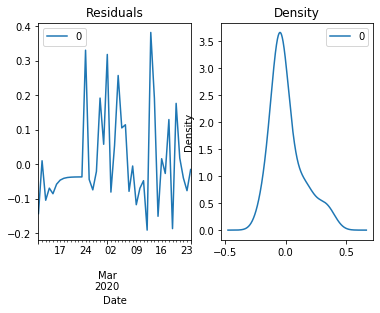

In [459]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [293]:
len(test_uk)

20

Text(0, 0.5, 'log of cases')

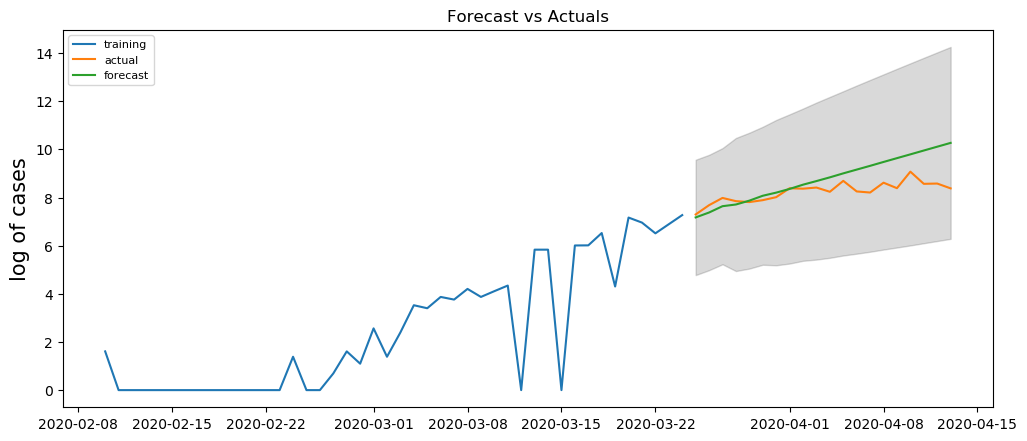

In [294]:
# MULTI_STEP Forecast
fc, se, conf = model_fit.forecast(20, alpha=0.05) # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test_uk_log.index)
lower_series = pd.Series(conf[:, 0], index=test_uk_log.index)
upper_series = pd.Series(conf[:, 1], index=test_uk_log.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_uk_log, label='training')
plt.plot(test_uk_log, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.ylabel('log of cases', fontsize=15)
#plt.savefig('myfig2.pdf')

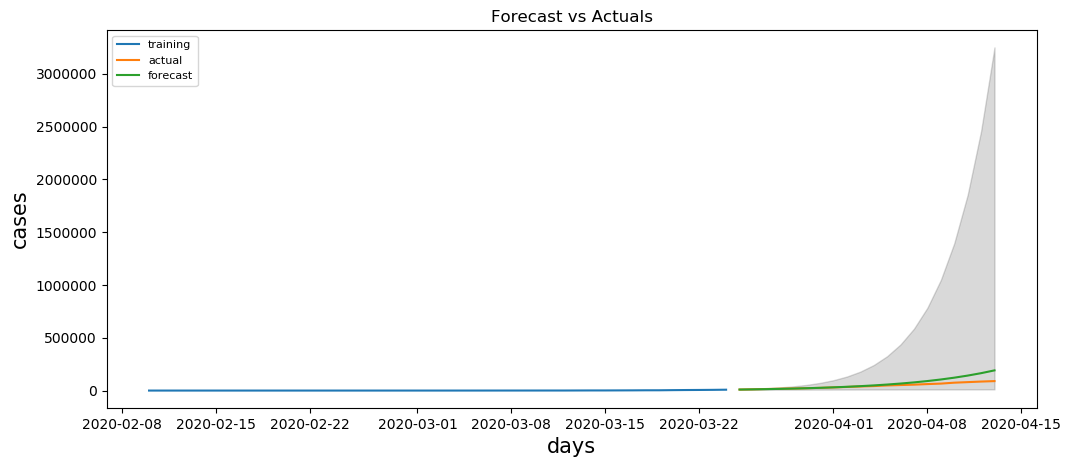

In [200]:
# Plot real
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_uk['Confirmed'], label='training')
plt.plot(test_uk['Confirmed'], label='actual')
plt.plot(np.exp(fc_series), label='forecast')
plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('days', fontsize=15)
plt.ylabel('cases', fontsize=15)
#plt.yscale('log')
plt.show()

In [204]:
forecast = model_fit.forecast(steps=20)[0]
#forecast = np.array(forecast, dtype='int')
forecast

array([ 9.17691021,  9.34154245,  9.51234816,  9.67822663,  9.84097123,
       10.00366889, 10.16456871, 10.32369251, 10.48181565, 10.63877043,
       10.79455869, 10.94939896, 11.10334163, 11.25643092, 11.40875769,
       11.56038311, 11.71135718, 11.861736  , 12.01156851, 12.16089756])

In [205]:
test_uk_log

,Confirmed
Date,
2020-03-25,9.173676
2020-03-26,9.376871
2020-03-27,9.598659
2020-03-28,9.759155
2020-03-29,9.892427
2020-03-30,10.019180
2020-03-31,10.145688
2020-04-01,10.304443
2020-04-02,10.439191


In [206]:
y_pred=np.exp(forecast)
y_pred = np.array(y_pred, dtype='int')
y_test = test_uk['Confirmed'].values
df = {'Prediction values':  y_pred,
        'Actual values': y_test
        }
df = pd.DataFrame (df, columns = ['Prediction values','Actual values' ])

In [207]:
df

,Prediction values,Actual values
0,9671,9640.0
1,11401,11812.0
2,13525,14745.0
3,15966,17312.0
4,18787,19780.0
5,22107,22453.0
6,25966,25481.0
7,30445,29865.0
8,35661,34173.0
9,41721,38689.0


In [208]:
forecast_accuracy(y_pred, y_test)

{'MAPE': 29.668348339163998,
 'ME': 20473.25,
 'MAE': 20904.85,
 'MPE': 0.2705938068629171,
 'RMSE': 35935.617691226624}

In [610]:
#RANDOM WALK
predictions = []
for i in range(len(test_uk.index)):
    if i == 0:
        predictions.append(train_uk['Confirmed'].values[-1])
    else:
        predictions.append(test_uk['Confirmed'].values[i-1])
    
predictions = np.transpose(np.array([row.tolist() for row in predictions]))

In [238]:
predictions

array([ 8164.,  9640., 11812., 14745., 17312., 19780., 22453., 25481.,
       29865., 34173., 38689., 42477., 48436., 52279., 55949., 61474.,
       65872., 74605., 79874., 85206.])

In [239]:
forecast_accuracy(predictions, y_test)

{'MAPE': 11.193498332674077,
 'ME': -4070.3,
 'MAE': 4070.3,
 'MPE': -0.11193498332674076,
 'RMSE': 4371.109836185771}

In [641]:
ar_order = np.ones(6)
mod = sm.tsa.SARIMAX(train_uk_log, order=(ar_order, 2, 1), )
# Estimate the parameters
res = mod.fit()
print(res.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                   44
Model:               SARIMAX(6, 2, 1)   Log Likelihood                  23.573
Date:                Tue, 14 Apr 2020   AIC                            -31.146
Time:                        21:09:16   BIC                            -17.245
Sample:                    02-10-2020   HQIC                           -26.051
                         - 03-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3390    130.755     -0.003      0.998    -256.614     255.936
ar.L2         -0.2162    124.679     -0.002      0.999    -244.583     244.150
ar.L3          0.0850    104.894      0.001      0.9

In [357]:
np.ones(3)

array([1., 1., 1.])

In [360]:
ar_order[1]

0.0

In [643]:
ar_order = np.ones(7)
ar_order[[1,2,3,4,5]] = 0
mod = sm.tsa.SARIMAX(train_uk_log, order=(ar_order, 1, 0))
res = mod.fit()
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                 Confirmed   No. Observations:                   44
Model:             SARIMAX([1, 7], 1, 0)   Log Likelihood                  17.319
Date:                   Tue, 14 Apr 2020   AIC                            -28.639
Time:                           21:10:11   BIC                            -23.355
Sample:                       02-10-2020   HQIC                           -26.690
                            - 03-24-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3959      0.139      2.853      0.004       0.124       0.668
ar.L7          0.3877      0.126      3.076      0.002       0.141       0.635
sigma2         0.0252      0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



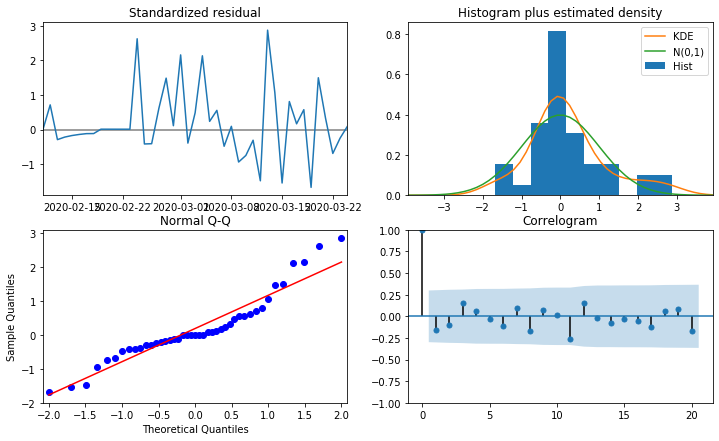

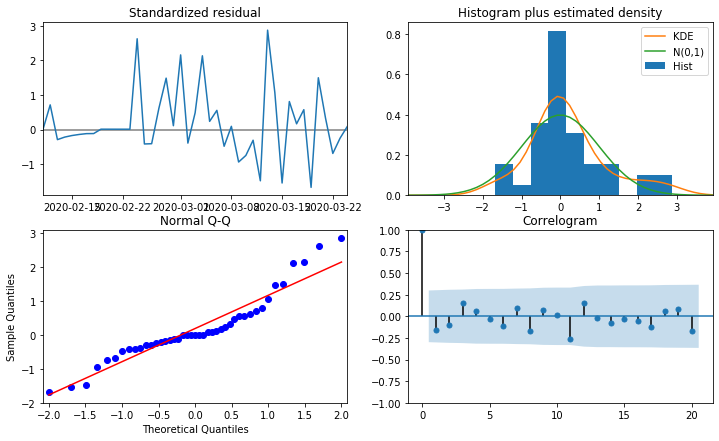

In [519]:
res.plot_diagnostics(figsize = (12, 7), lags=20)

In [644]:
res.params

ar.L1     0.395900
ar.L7     0.387747
sigma2    0.025169
dtype: float64

In [646]:
mod2 = sm.tsa.SARIMAX(uk_new_log, order=(ar_order, 1, 0))
res2 = mod2.smooth(res.params)
print(res2.summary())

                                 SARIMAX Results                                 
Dep. Variable:                 Confirmed   No. Observations:                   64
Model:             SARIMAX([1, 7], 1, 0)   Log Likelihood                  35.241
Date:                   Tue, 14 Apr 2020   AIC                            -64.482
Time:                           21:10:37   BIC                            -58.052
Sample:                       02-10-2020   HQIC                           -61.953
                            - 04-13-2020                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3959      0.138      2.877      0.004       0.126       0.666
ar.L7          0.3877      0.126      3.088      0.002       0.142       0.634
sigma2         0.0252      0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



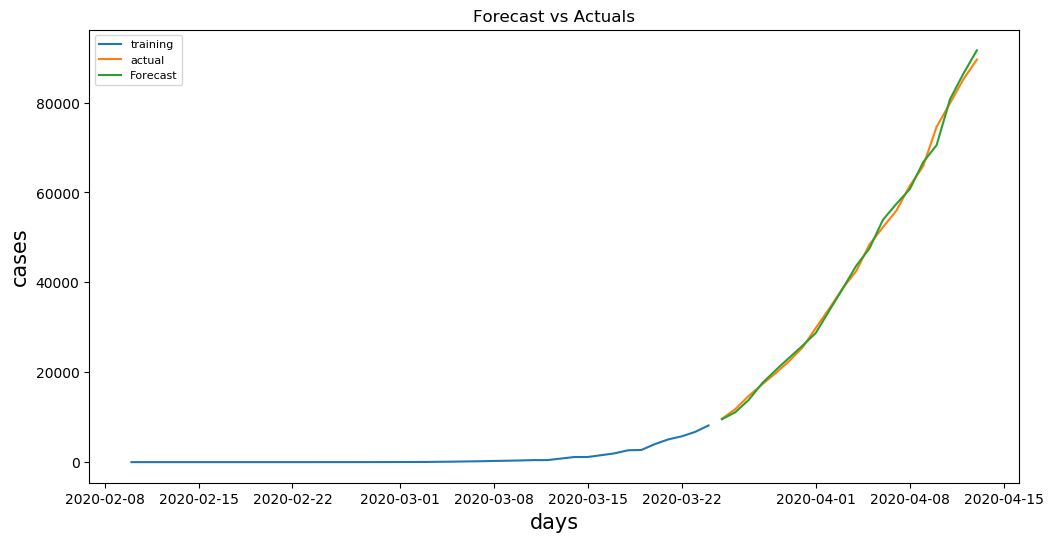

In [630]:
# Plot real one -step forecasr
plt.figure(figsize=(12,6), dpi=100)
plt.plot(train_uk['Confirmed'], label='training')
plt.plot(test_uk['Confirmed'], label='actual')
plt.plot(np.exp(res2.predict(start=44, end=len(uk_new_log)-1)), label = 'Forecast')
#plt.fill_between(lower_series.index, np.exp(lower_series), np.exp(upper_series), 
                 #color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xlabel('days', fontsize=15)
plt.ylabel('cases', fontsize=15)
#plt.yscale('log')
plt.savefig('myfig4.png')
plt.show()

In [647]:
fc=res2.predict(start=44, end=len(uk_new_log)-1)

In [634]:
np.exp(fc)

2020-03-25     9554.848120
2020-03-26    11117.513352
2020-03-27    13860.274061
2020-03-28    17546.409479
2020-03-29    20450.079889
2020-03-30    23195.362292
2020-03-31    25888.847751
2020-04-01    28769.034798
2020-04-02    33706.923096
2020-04-03    38581.870596
2020-04-04    43654.833081
2020-04-05    47578.734101
2020-04-06    53926.656505
2020-04-07    57458.624221
2020-04-08    60732.191559
2020-04-09    66741.258361
2020-04-10    70541.494083
2020-04-11    80750.225837
2020-04-12    86459.055927
2020-04-13    91629.901936
Freq: D, dtype: float64

In [648]:
y_pred=np.exp(fc)
y_pred = np.array(y_pred, dtype='int')
y_test = test_uk['Confirmed'].values
df = {'Prediction values':  y_pred,
        'Actual values': y_test
        }
df = pd.DataFrame (df, columns = ['Prediction values','Actual values' ])

In [649]:
df

,Prediction values,Actual values
0,9896,9640.0
1,10406,11812.0
2,14895,14745.0
3,17620,17312.0
4,19362,19780.0
5,22172,22453.0
6,25450,25481.0
7,28572,29865.0
8,34409,34173.0
9,39282,38689.0


In [650]:
df.set_index(test_uk.index, inplace=True)
df

,Prediction values,Actual values
Date,,
2020-03-25,9896,9640.0
2020-03-26,10406,11812.0
2020-03-27,14895,14745.0
2020-03-28,17620,17312.0
2020-03-29,19362,19780.0
2020-03-30,22172,22453.0
2020-03-31,25450,25481.0
2020-04-01,28572,29865.0
2020-04-02,34409,34173.0


In [651]:
forecast_accuracy(y_pred, y_test)

{'MAPE': 2.403020218235663,
 'ME': -37.4,
 'MAE': 899.9,
 'MPE': -0.005221507011460734,
 'RMSE': 1213.8253993058474}

In [613]:
ar_order = np.ones(14)
ar_order[[1,2,3,4,5,7,8,9,10,11,12]] = 0
mod = sm.tsa.SARIMAX(train_uk_log, order=(ar_order, 1, 1))
res = mod.fit()
print(res.summary())

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



                                   SARIMAX Results                                   
Dep. Variable:                     Confirmed   No. Observations:                   44
Model:             SARIMAX([1, 7, 14], 1, 1)   Log Likelihood                  22.703
Date:                       Tue, 14 Apr 2020   AIC                            -35.406
Time:                               17:58:55   BIC                            -26.600
Sample:                           02-10-2020   HQIC                           -32.159
                                - 03-24-2020                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1236      0.205      5.486      0.000       0.722       1.525
ar.L7         -0.1117      0.193     -0.577      0.564      -0.491       0.

/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [614]:
mod2 = sm.tsa.SARIMAX(uk_new_log, order=(ar_order, 1, 1))
res2 = mod2.smooth(res.params)
print(res2.summary())

                                   SARIMAX Results                                   
Dep. Variable:                     Confirmed   No. Observations:                   64
Model:             SARIMAX([1, 7, 14], 1, 1)   Log Likelihood                  43.268
Date:                       Tue, 14 Apr 2020   AIC                            -76.536
Time:                               17:58:57   BIC                            -65.820
Sample:                           02-10-2020   HQIC                           -72.321
                                - 04-13-2020                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1236      0.190      5.923      0.000       0.752       1.495
ar.L7         -0.1117      0.182     -0.614      0.539      -0.469       0.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [615]:
fc=res2.predict(start=44, end=len(uk_new_log)-1)
y_pred=np.exp(fc)
y_pred = np.array(y_pred, dtype='int')
y_test = test_uk['Confirmed'].values
df = {'Prediction values':  y_pred,
        'Actual values': y_test
        }
df = pd.DataFrame (df, columns = ['Prediction values','Actual values' ])
df.set_index(test_uk.index, inplace=True)
df

,Prediction values,Actual values
Date,,
2020-03-25,9675,9640.0
2020-03-26,11624,11812.0
2020-03-27,13846,14745.0
2020-03-28,17221,17312.0
2020-03-29,20341,19780.0
2020-03-30,23070,22453.0
2020-03-31,25904,25481.0
2020-04-01,29141,29865.0
2020-04-02,34052,34173.0


In [616]:
forecast_accuracy(y_pred, y_test)

{'MAPE': 1.898475646133759,
 'ME': -145.15,
 'MAE': 770.95,
 'MPE': -0.003080393138372455,
 'RMSE': 1198.3225984683756}

In [608]:

mod = sm.tsa.SARIMAX(train_uk_log, order=(1, 1, 2))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                   44
Model:               SARIMAX(1, 1, 2)   Log Likelihood                  23.473
Date:                Tue, 14 Apr 2020   AIC                            -38.946
Time:                        17:38:53   BIC                            -31.902
Sample:                    02-10-2020   HQIC                           -36.349
                         - 03-24-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9691      0.041     23.894      0.000       0.890       1.049
ma.L1         -1.0182      0.133     -7.638      0.000      -1.279      -0.757
ma.L2          0.3269      0.125      2.613      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [609]:
mod2 = sm.tsa.SARIMAX(uk_new_log, order=(1, 1, 2))
res2 = mod2.smooth(res.params)
print(res2.summary())

                               SARIMAX Results                                
Dep. Variable:              Confirmed   No. Observations:                   64
Model:               SARIMAX(1, 1, 2)   Log Likelihood                  44.265
Date:                Tue, 14 Apr 2020   AIC                            -80.531
Time:                        17:39:19   BIC                            -71.958
Sample:                    02-10-2020   HQIC                           -77.159
                         - 04-13-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9691      0.040     24.521      0.000       0.892       1.047
ma.L1         -1.0182      0.132     -7.691      0.000      -1.278      -0.759
ma.L2          0.3269      0.125      2.616      0.0

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [611]:
fc=res2.predict(start=44, end=len(uk_new_log)-1)
y_pred=np.exp(fc)
y_pred = np.array(y_pred, dtype='int')
y_test = test_uk['Confirmed'].values
df = {'Prediction values':  y_pred,
        'Actual values': y_test
        }
df = pd.DataFrame (df, columns = ['Prediction values','Actual values' ])
df.set_index(test_uk.index, inplace=True)
df

,Prediction values,Actual values
Date,,
2020-03-25,9655,9640.0
2020-03-26,11335,11812.0
2020-03-27,13784,14745.0
2020-03-28,17300,17312.0
2020-03-29,20662,19780.0
2020-03-30,23534,22453.0
2020-03-31,26256,25481.0
2020-04-01,29244,29865.0
2020-04-02,33762,34173.0


In [612]:
forecast_accuracy(y_pred, y_test)

{'MAPE': 2.4549782839998526,
 'ME': 366.65,
 'MAE': 994.85,
 'MPE': 0.005247921723411217,
 'RMSE': 1358.7474562993668}